przemyslec uzycie filmu, dolozyc przykladow, dolozyc metryk

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ultralytics import YOLO
import xml.etree.ElementTree as ET
import time
import pandas as pd

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax-xmin, ymax-ymin))
    return bboxes

def load_annotations_and_images(annotations_folder, images_folder):
    annotations_files = [f for f in os.listdir(annotations_folder) if f.endswith('.xml')]
    data = []
    i = 0
    for annotation_file in annotations_files:
        if i > 250:
            break
        i += 1
        xml_path = os.path.join(annotations_folder, annotation_file)
        image_name = annotation_file.replace('.xml', '.jpg')
        image_path = os.path.join(images_folder, image_name)

        if not os.path.exists(image_path):
            continue

        bboxes = parse_xml(xml_path)
        image = cv2.imread(image_path)
        data.append((image, bboxes))
    return data

def load_single_annotation_and_image(annotation_file, images_folder):
    xml_path = annotation_file
    image_name = os.path.basename(annotation_file).replace('.xml', '.jpg')
    image_path = os.path.join(images_folder, image_name)

    if not os.path.exists(image_path):
        print(f"Image file {image_path} does not exist.")
        return None

    bboxes = parse_xml(xml_path)
    image = cv2.imread(image_path)
    return image, bboxes

In [3]:
def process_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    new_height = ((height // 32) + (height % 32 > 0)) * 32
    new_width = ((width // 32) + (width % 32 > 0)) * 32
    img = cv2.resize(img, (new_width, new_height))

    img = img / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).float()
    return img

In [4]:
# counting iou between two boxes
def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

In [5]:
def calculate_metrics(y_true, y_pred, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_preds = []

    for bbox_true in y_true:
        best_iou = 0
        best_pred = None
        for bbox_pred in y_pred:
            current_iou = iou(bbox_true, bbox_pred)
            if current_iou >= iou_threshold and current_iou > best_iou:
                best_iou = current_iou
                best_pred = bbox_pred
        if best_pred:
            matched_preds.append(best_pred)
            y_pred.remove(best_pred)
            true_positives += 1
        else:
            false_negatives += 1

    false_positives = len(y_pred)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, accuracy, f1_score

In [6]:
def plot_figure(index, original_img, version):
    if not index % 50:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Results for {version}')
        plt.axis('off')
        plt.show()

In [7]:
def plot_elapsed_times(yolo_versions, elapsed_times):
    plt.figure(figsize=(10, 6))
    for i, (version, _) in enumerate(yolo_versions.items()):
        plt.bar(version, elapsed_times[i], label=version)
    plt.xlabel('Versions')
    plt.ylabel('Elapsed Time (seconds)')
    plt.title('Elapsed Time for Each YOLO Version')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def append_metrics(y_true, y_pred):
    precision, recall, accuracy, f1_score = calculate_metrics(y_true, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

In [9]:
def print_metrics():
    metrics_df = pd.DataFrame(metrics)
    print("Metrics Comparison:")
    print(metrics_df)

    plot_elapsed_times(yolo_versions, elapsed_times)

    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
    metrics_columns = metrics_df.columns.drop('Model')

    for i, metric in enumerate(metrics_columns):
        color = colors[i % len(colors)]
        metrics_df.plot(x='Model', y=metric, kind='bar', figsize=(10, 5), title=f"{metric} Comparison", color=color)
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.show()

In [10]:
# List of YOLO versions with their configurations
yolo_versions = {
    'yolov2': {'cfg': 'configs/yolov2.cfg', 'weights': 'weights/yolov2.weights'},
    'yolov3': {'cfg': 'configs/yolov3.cfg', 'weights': 'weights/yolov3.weights'},
    'yolov4': {'cfg': 'configs/yolov4.cfg', 'weights': 'weights/yolov4.weights'},
    'yolov5': {'model': 'yolov5mu.pt'},
    'yolov8': {'model': 'yolov8m.pt'},
    'yolov9': {'model': 'yolov9c.pt'}
}

metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'Accuracy': [],
    'F1_Score': []
}
images, bboxes = zip(*load_annotations_and_images('annotations', 'JPEGImages'))
elapsed_times = []

In [17]:
def generate_adversarial_example(image, epsilon):
    perturbation = np.random.uniform(-epsilon, epsilon, image.shape).astype(np.float32)
    adversarial_image = image + perturbation
    return np.clip(adversarial_image, 0, 255).astype(np.uint8)

c:\Users\Patryk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Patryk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Time taken for yolov2: 0.00 seconds
Time taken for yolov3: 0.00 seconds
Time taken for yolov4: 0.00 seconds

0: 512x512 1 person, 300.1ms
Speed: 1.0ms preprocess, 300.1ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)

0: 640x640 1 person, 449.3ms
Speed: 5.0ms preprocess, 449.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


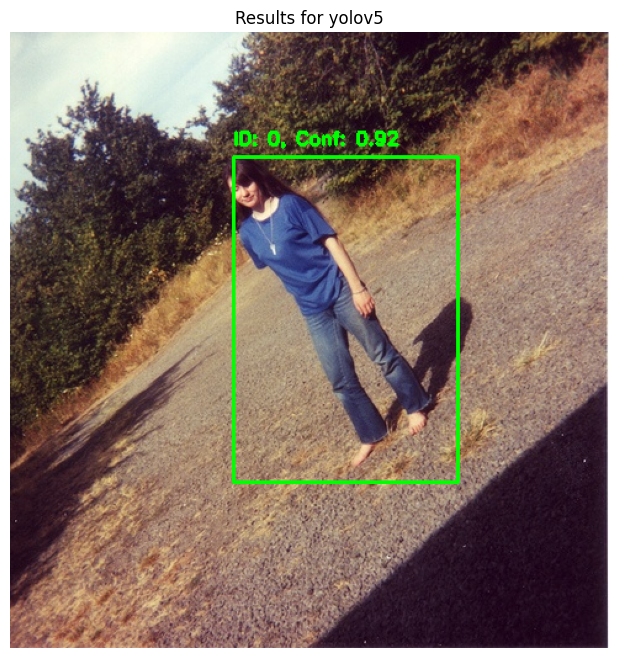


0: 288x512 2 persons, 2 airplanes, 2 trucks, 245.4ms
Speed: 0.0ms preprocess, 245.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 512)

0: 384x640 2 persons, 2 airplanes, 2 trucks, 291.7ms
Speed: 2.0ms preprocess, 291.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x512 5 airplanes, 236.7ms
Speed: 0.0ms preprocess, 236.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 512)

0: 480x640 7 airplanes, 1 truck, 348.4ms
Speed: 3.2ms preprocess, 348.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x512 1 tv, 1 mouse, 1 keyboard, 2 refrigerators, 229.2ms
Speed: 0.0ms preprocess, 229.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 512)

0: 480x640 1 bowl, 1 tv, 1 mouse, 1 keyboard, 336.9ms
Speed: 1.5ms preprocess, 336.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x512 2 trains, 233.3ms
Speed: 0.0ms preprocess, 233.3ms inference, 2.0ms postprocess per image at shape

In [ ]:
# Loop through each YOLO version
for version, paths in yolo_versions.items():
    start_time = time.time()
    precisions, recalls, accuracies, f1_scores = [], [], [], []

    if version in ['yolov5', 'yolov8', 'yolov9']:
        model = YOLO(paths['model'])
        
        for index, image in enumerate(images):
            y_true = bboxes[index]
            y_pred = []
            img_tensor = process_image(image)
            original_img = image.copy()
            results = model(img_tensor)
            
            y_pred_adv = []
            adversarial_image = generate_adversarial_example(image, 0.3)
            results_adv = model(adversarial_image) if model else None
            for result in results_adv:
                for detection in result.boxes:
                    x1, y1, x2, y2 = map(int, detection.xyxy[0])
                    conf = detection.conf[0].item()
                    if conf > 0.5:
                        y_pred_adv.append((x1, y1, x2 - x1, y2 - y1))
                
            for result in results:
                for detection in result.boxes:
                    x1, y1, x2, y2 = map(int, detection.xyxy[0])
                    conf = detection.conf[0].item()
                    cls = detection.cls[0].item()

                    if conf > 0.5:
                        x = x1
                        y = y1
                        w = x2 - x1
                        h = y2 - y1
                        y_pred.append((x, y, w, h))
                        cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                        cv2.putText(original_img, f"ID: {int(cls)}, Conf: {conf:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            for preds in [y_pred, y_pred_adv]:
                precision, recall, accuracy, f1_score = calculate_metrics(y_true, preds)
                precisions.append(precision)
                recalls.append(recall)
                accuracies.append(accuracy)
                f1_scores.append(f1_score)

            plot_figure(index, original_img, version)
            append_metrics(y_true, y_pred)

    # else:
    #     # Reading YOLOv2 - YOLOv4 models
    #     net = cv2.dnn.readNetFromDarknet(paths['cfg'], paths['weights'])
    #     for index, image in enumerate(images):
    #         original_img = image.copy()
    #         y_true = bboxes[index]
    #         y_pred = []
    #         blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    #         net.setInput(blob)

    #         layer_names = net.getLayerNames()
    #         output_layer_indices = net.getUnconnectedOutLayers().flatten()
    #         output_layers = [layer_names[i - 1] for i in output_layer_indices]
    #         detections = net.forward(output_layers)
    #         detected_classes = {}
    #         boxes = []
    #         confidences = []
    #         class_ids = []

    #         for output in detections:
    #             for detection in output:
    #                 scores = detection[5:]
    #                 class_id = np.argmax(scores)
    #                 confidence = scores[class_id]
    #                 if confidence > 0.5:
    #                     box = detection[0:4] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
    #                     (centerX, centerY, width, height) = box.astype("int")
    #                     x = int(centerX - (width / 2))
    #                     y = int(centerY - (height / 2))

    #                     boxes.append([x, y, int(width), int(height)])
    #                     confidences.append(float(confidence))
    #                     class_ids.append(class_id)

    #         indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)
    #         detected_classes = {}

    #         if len(indices) > 0 and isinstance(indices, tuple):
    #             indices = indices[0]

    #         for i in indices:
    #             x, y, w, h = boxes[i[0]] if isinstance(i, tuple) else boxes[i]
    #             confidence, class_id = confidences[i], class_ids[i]
    #             cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #             cv2.putText(original_img, f"ID: {class_id}, Conf: {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    #             detected_classes[class_id] = detected_classes.get(class_id, 0) + 1
    #             y_pred.append((x, y, w, h))

    #         plot_figure(index, original_img, version)
    #         append_metrics(y_true, y_pred)

    metrics['Model'].append(version)
    metrics['Precision'].append(np.mean(precisions))
    metrics['Recall'].append(np.mean(recalls))
    metrics['Accuracy'].append(np.mean(accuracies))
    metrics['F1_Score'].append(np.mean(f1_scores))

    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    print(f"Time taken for {version}: {elapsed_time:.2f} seconds")

Metrics Comparison:
    Model  Precision    Recall  Accuracy  F1_Score
0  yolov2   0.932935  0.744063  0.739880  0.796066
1  yolov3   0.794594  0.813699  0.709553  0.779252
2  yolov4   0.816140  0.858618  0.736943  0.808782
3  yolov5   0.769280  0.831626  0.692783  0.771176
4  yolov8   0.786196  0.852429  0.715185  0.790967
5  yolov9   0.778656  0.851166  0.708453  0.785977


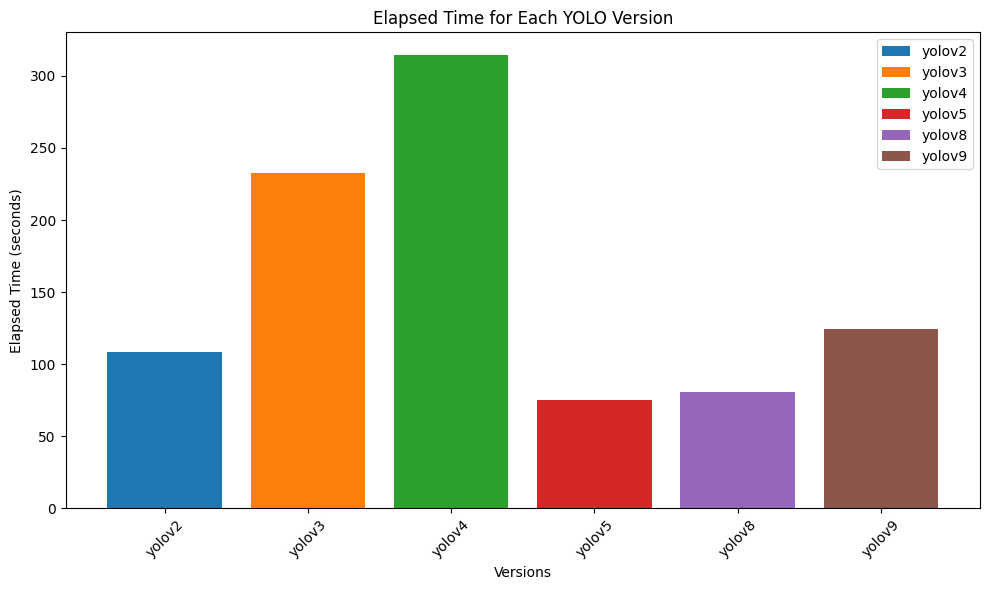

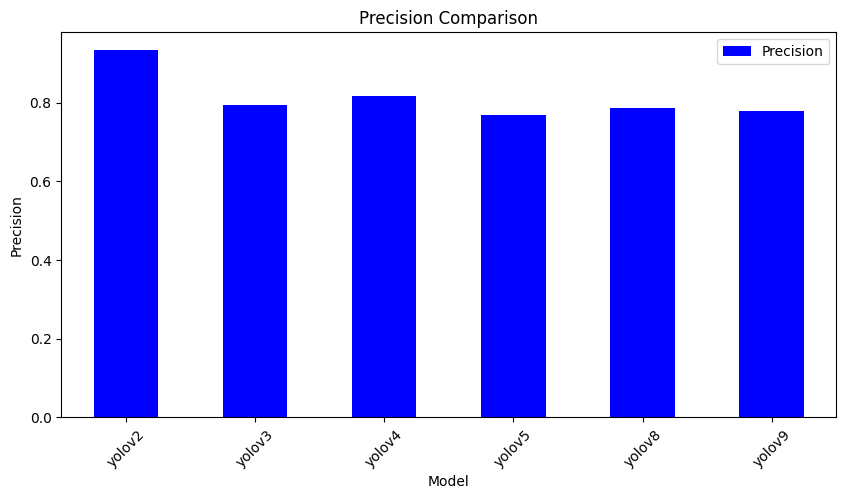

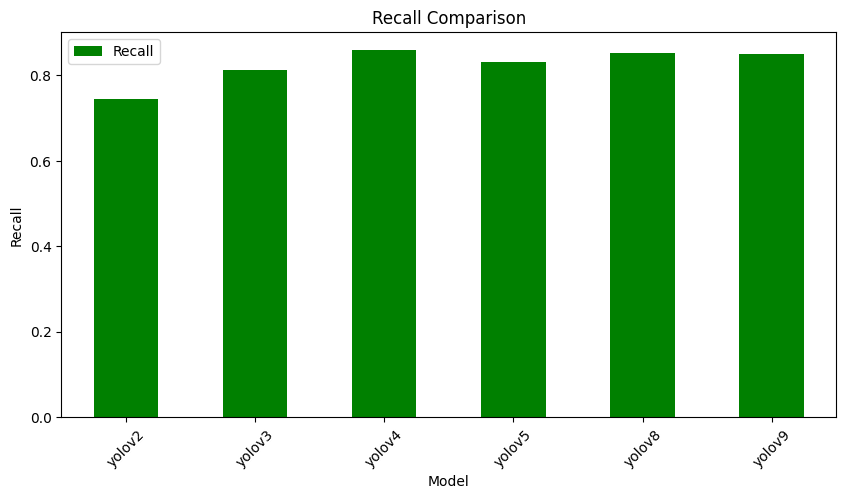

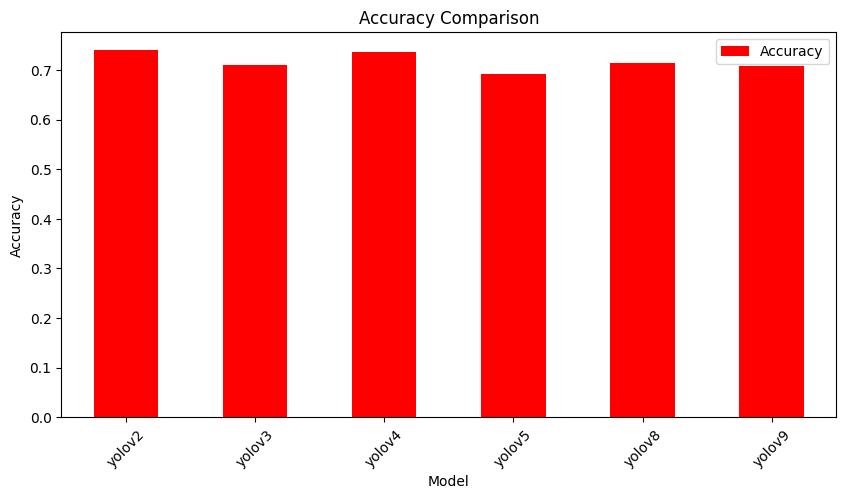

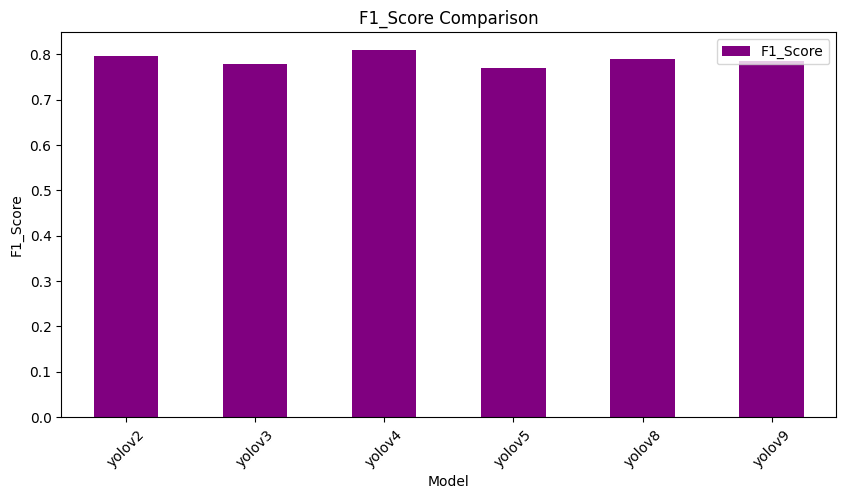

In [ ]:
print_metrics()